In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nattaponkamboonsri","key":"f505fbaa35eb45b5c6c90926ae459697"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d surajghuwalewala/ham1000-segmentation-and-classification
! unzip ham1000-segmentation-and-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: masks/ISIC_0029321_segmentation.png  
  inflating: masks/ISIC_0029322_segmentation.png  
  inflating: masks/ISIC_0029323_segmentation.png  
  inflating: masks/ISIC_0029324_segmentation.png  
  inflating: masks/ISIC_0029325_segmentation.png  
  inflating: masks/ISIC_0029326_segmentation.png  
  inflating: masks/ISIC_0029327_segmentation.png  
  inflating: masks/ISIC_0029328_segmentation.png  
  inflating: masks/ISIC_0029329_segmentation.png  
  inflating: masks/ISIC_0029330_segmentation.png  
  inflating: masks/ISIC_0029331_segmentation.png  
  inflating: masks/ISIC_0029332_segmentation.png  
  inflating: masks/ISIC_0029333_segmentation.png  
  inflating: masks/ISIC_0029334_segmentation.png  
  inflating: masks/ISIC_0029335_segmentation.png  
  inflating: masks/ISIC_0029336_segmentation.png  
  inflating: masks/ISIC_0029337_segmentation.png  
  inflating: masks/ISIC_0029338_segmentation.png  
  inflating: masks/ISIC_0029339

In [4]:
! nvidia-smi

Fri Dec 12 20:26:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
!pip install pytorch-lightning
!pip install torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 60.5 MB/s eta 0:00:00


In [6]:
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image
from random import randint

# pytorch libraries
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [7]:
df=pd.read_csv('GroundTruth.csv')
print (df.head())
print (len(df))
print (df.columns)

          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0
10015
Index(['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], dtype='object')


In [8]:
df['image']=df['image'].apply(lambda x: x+ '.jpg')
print (df.head())

              image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310.jpg  1.0  0.0  0.0    0.0  0.0  0.0   0.0


In [9]:
lesion_type_dict = {
    'NV': 'Melanocytic nevi',
    'MEL': 'Melanoma',
    'BKL': 'Benign keratosis like lesions',
    'BCC': 'Basal cell carcinoma',
    'AKIEC': 'Actinic keratoses',
    'VASC': 'Vascular lesions',
    'DF': 'Dermatofibroma'
}

labels = list(df.columns[1:])
label_list=[]
for i in range (len(df)):
    row= list(df.iloc[i])[1:]
    index=np.argmax(row)
    label=lesion_type_dict[labels[index]]
    label_list.append(label)
df['label']= label_list
df=df.drop(labels, axis=1)
df['label_idx'] = pd.Categorical(df['label']).codes
print(df.head())

              image             label  label_idx
0  ISIC_0024306.jpg  Melanocytic nevi          4
1  ISIC_0024307.jpg  Melanocytic nevi          4
2  ISIC_0024308.jpg  Melanocytic nevi          4
3  ISIC_0024309.jpg  Melanocytic nevi          4
4  ISIC_0024310.jpg          Melanoma          5


In [10]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image      10015 non-null  object
 1   label      10015 non-null  object
 2   label_idx  10015 non-null  int8  
dtypes: int8(1), object(2)
memory usage: 166.4+ KB


In [11]:
train_split=.9 # set this to the percentof the data you want to use for training
valid_split=.025 # set this to the percent of the data you want to use for validation
# Note percent of data sed for test is 1-train_split-valid_split

valid_split=valid_split/(1-train_split)
train_test_split
train_df, val_test_df = train_test_split(df, train_size=train_split, random_state=62)
val_df, test_df = train_test_split(val_test_df, train_size=valid_split, random_state=62)
print('Data Len Train:', len(train_df), 'Val:', len(val_df), 'Test:', len(test_df))

Data Len Train: 9013 Val: 250 Test: 752


In [12]:
max_size=100 # set maximum number of samples for each class
samples=[]
group=train_df.groupby('label')
for label in train_df['label'].unique():
    Lgroup=group.get_group(label)
    count=int(Lgroup['label'].value_counts())
    if count>=max_size:
        sample=Lgroup.sample(max_size, axis=0)
    else:
        sample=Lgroup.sample(frac=1, axis=0)
    samples.append(sample)
train_df=pd.concat(samples, axis=0).reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print(train_df['label'].value_counts())

label
Melanocytic nevi                 100
Benign keratosis like lesions    100
Basal cell carcinoma             100
Melanoma                         100
Actinic keratoses                100
Vascular lesions                 100
Dermatofibroma                   100
Name: count, dtype: int64


/tmp/ipython-input-1244045208.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  count=int(Lgroup['label'].value_counts())
/tmp/ipython-input-1244045208.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  count=int(Lgroup['label'].value_counts())
/tmp/ipython-input-1244045208.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  count=int(Lgroup['label'].value_counts())
/tmp/ipython-input-1244045208.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  count=int(Lgroup['label'].value_counts())
/tmp/ipython-input-1244045208.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a Typ

In [29]:
train_transform = transforms.Compose(
    [transforms.Resize((230,230)),
        transforms.RandomRotation(30,),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]) #nomalize imagenet pretrain
    ])

val_transform = transforms.Compose(
    [transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ])

In [30]:
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(os.path.join('images', self.df['image'][index]))
        y = torch.tensor(int(self.df['label_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [31]:
BATCH_SIZE = 64
NUM_WORKERS = 2

# Define the training,val,test sets using the tables and using our defined transitions
train_set = HAM10000(train_df, transform=train_transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

val_set = HAM10000(val_df, transform=val_transform)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

test_set = HAM10000(test_df, transform=val_transform)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print('Data Len Train:', len(train_set), 'Val:', len(val_set), 'Test:', len(test_set))

Data Len Train: 700 Val: 250 Test: 752


In [32]:
from torchmetrics.classification import Accuracy
import pytorch_lightning as pl

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [33]:
class LitEfficientNetV2(pl.LightningModule):
    def __init__(self, num_classes=10, learning_rate=1e-3):
        super().__init__()
        # Load EfficientNetV2 model from torchvision
        self.model = models.efficientnet_v2_s(weights="IMAGENET1K_V1")
        # Replace the classifier with a custom layer for our task
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.learning_rate = learning_rate
        self.train_metrics = []
        self.val_metrics = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.accuracy(logits.argmax(dim=1), y)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.accuracy(logits.argmax(dim=1), y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True)

    def on_train_epoch_end(self):
        # Collect epoch metrics

        train_loss = self.trainer.callback_metrics["train_loss"]
        train_acc = self.trainer.callback_metrics["train_acc"]
        self.train_metrics.append(
            {
                "epoch": self.current_epoch,
                "train_loss": train_loss.item(),
                "train_acc": train_acc.item(),
            }
        )

    def on_validation_epoch_end(self):
        # Update validation metrics
        val_loss = self.trainer.callback_metrics["val_loss"]
        val_acc = self.trainer.callback_metrics["val_acc"]
        self.val_metrics.append(
            {
                "val_loss": val_loss.item(),
                "val_acc": val_acc.item(),
            }
        )

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

net = LitEfficientNetV2().to(device)

In [34]:
from pytorch_lightning.callbacks import ModelCheckpoint

In [35]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",       # Monitor validation accuracy
    mode="max",              # Save the model with the highest accuracy
    save_top_k=1,            # Save only the best model
    filename="efficientnetv2-best-{epoch:02d}-{val_acc:.4f}",  # File name format
    verbose=True             # Print messages when saving
)

In [36]:
trainer = pl.Trainer(max_epochs=5, callbacks=[checkpoint_callback])
trainer.fit(net, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ EfficientNet       │ 20.2 M │ train │     0 │
│ 1 │ criterion │ CrossEntropyLoss   │      0 │ train │     0 │
│ 2 │ accuracy  │ MulticlassAccuracy │      0 │ train │     0 │
└───┴───────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 20.2 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 20.2 M                                                                                               
Total estimated model params size (MB): 80                                                                         
Modules in train mode: 716                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 11: 'val_acc' reached 0.69200 (best 0.69200), saving model to '/content/lightning_logs/version_1/checkpoints/efficientnetv2-best-epoch=00-val_acc=0.6920.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 22: 'val_acc' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 33: 'val_acc' reached 0.73200 (best 0.73200), saving model to '/content/lightning_logs/version_1/checkpoints/efficientnetv2-best-epoch=02-val_acc=0.7320.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 44: 'val_acc' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 55: 'val_acc' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


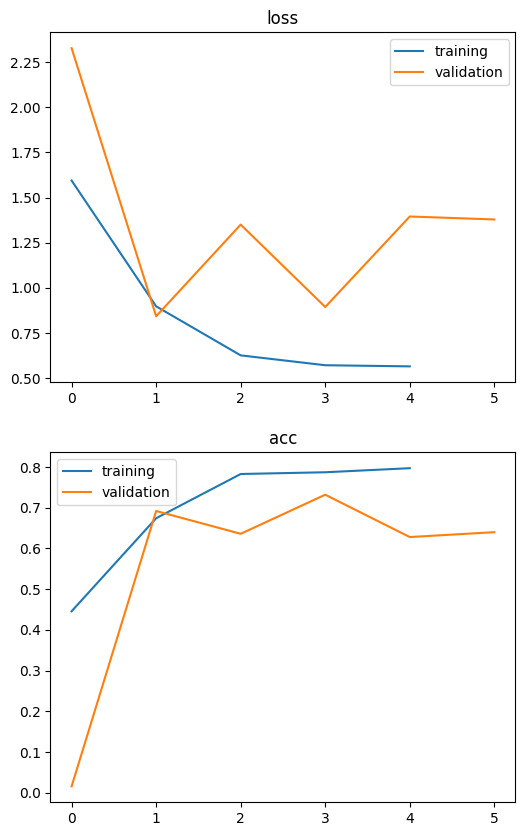

In [37]:
fig, axs = plt.subplots(2, figsize= (6,10))
# loss
axs[0].plot([entry['train_loss'] for entry in net.train_metrics], label = 'training')
axs[0].plot([entry['val_loss'] for entry in net.val_metrics], label = 'validation')
axs[0].set_title("loss")
axs[0].legend()
# acc
axs[1].plot([entry['train_acc'] for entry in net.train_metrics], label = 'training')
axs[1].plot([entry['val_acc'] for entry in net.val_metrics], label = 'validation')
axs[1].set_title("acc")
axs[1].legend()

In [38]:
from typing import NewType
print(f"Best model saved at: {checkpoint_callback.best_model_path}")

best_model_path = checkpoint_callback.best_model_path
best_model = LitEfficientNetV2.load_from_checkpoint(best_model_path).to(device)

# Use the best model for inference
best_model.eval()
best_model.freeze()

Best model saved at: /content/lightning_logs/version_1/checkpoints/efficientnetv2-best-epoch=02-val_acc=0.7320.ckpt


In [40]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

criterion = nn.CrossEntropyLoss()
print('testing ...')
y_predict = list()
y_labels = list()
test_loss = 0.0
n = 0
with torch.no_grad():
    for data in tqdm(test_loader):

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        y_labels += list(labels.cpu().numpy())
        y_predict += list(outputs.argmax(dim=1).cpu().numpy())
        # To get probabilities, you can run a softmax on outputs
        y_probs = torch.nn.functional.softmax(outputs, dim=1)
        y_probs = list(y_probs.cpu().numpy())
        n+=1

    # print statistics
    test_loss /= n
    print(f"testing loss: {test_loss:.4}" )

    report = classification_report(y_labels, y_predict, digits = 4)
    M = confusion_matrix(y_labels, y_predict)
    print(report)
    disp = ConfusionMatrixDisplay(confusion_matrix=M)

testing ...


100%|██████████| 12/12 [00:10<00:00,  1.17it/s]

testing loss: 0.9851
              precision    recall  f1-score   support

           0     1.0000    0.2059    0.3415        34
           1     0.7143    0.5714    0.6349        35
           2     0.5324    0.7708    0.6298        96
           3     0.2500    0.8750    0.3889         8
           4     0.9532    0.7061    0.8113       490
           5     0.2778    0.5128    0.3604        78
           6     0.2558    1.0000    0.4074        11

    accuracy                         0.6715       752
   macro avg     0.5691    0.6632    0.5106       752
weighted avg     0.8027    0.6715    0.7015       752



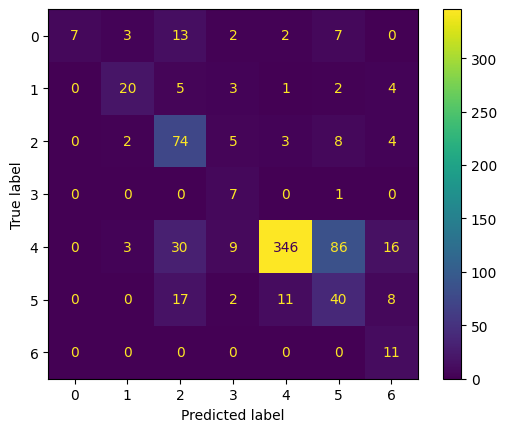

In [41]:
disp.plot()
plt.show()

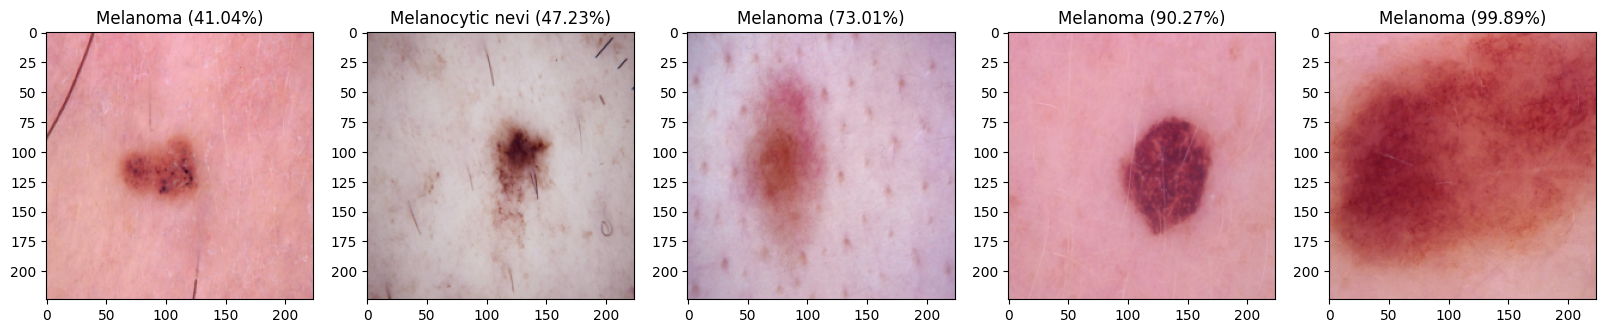

In [47]:
plt.figure(figsize=(20,5))
dataiter = iter(test_loader)
inputs, labels = next(dataiter)
with torch.no_grad():

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        y_labels = list(labels.cpu().numpy())
        y_predict = list(outputs.argmax(dim=1).cpu().numpy())
        # To get probabilities, you can run a softmax on outputs
        y_probs = torch.nn.functional.softmax(outputs, dim=1)
        y_probs = list(y_probs.cpu().numpy())

# We selected a sample from the first five images for visualization
for i in range(5):
    plt.subplot(1,5,i+1)
    img = inputs[i]
    img = img*torch.tensor([0.267, 0.256, 0.276]).mean() + torch.tensor([0.507, 0.487, 0.441]).mean()     # unnormalize
    npimg = img.cpu().numpy()
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    most_prob = np.argmax(y_probs[i])
    label = df['label'][most_prob]
    prob = y_probs[i][most_prob]
    plt.title(f"{label} ({prob*100:.2f}%)")